In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import torch

In [2]:
from utils.data_loading import *
from model.train import *
from model.test import *

Loading data set SignMNIST from openml...
Finished loading
Splitting the data to 80% training data and  20% test data, with random state = 42
Training data size: 27701
Test data size: 6926
Displaying classes distribution. Close the figure windows tocontinue...


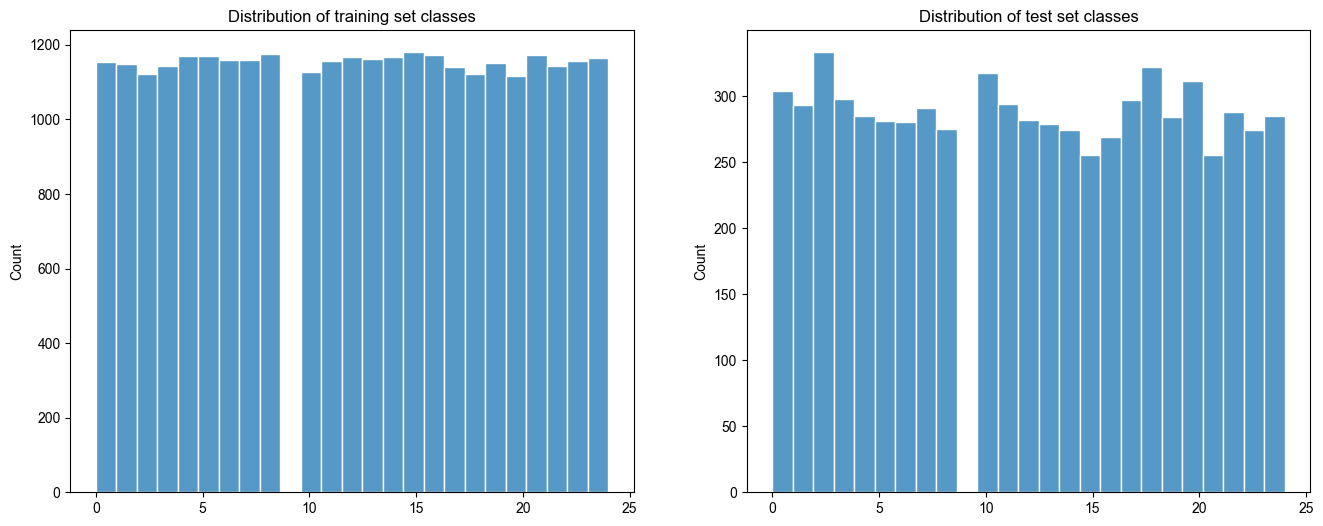

In [3]:
mnist = get_dataset_openml()
X_train, X_test, y_train, y_test = data_preprocessing(mnist)

In [4]:
model = train_model_fc(X_train, y_train)

Training a fully connected neural network for 100 epochs,with learning rate 0.02
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.1972       0.0534        3.1802  0.9098
      2        3.1555       0.1175        3.1234  0.7843
      3        3.0642       0.1180        2.9843  0.7800
      4        2.8857       0.1554        2.7955  0.7377
      5        2.7105       0.1825        2.6421  0.7296
      6        2.5373       0.2012        2.4831  0.7894
      7        2.3321       0.2158        2.3243  0.7570
      8        2.1453       0.2570        2.1817  0.7696
      9        2.0043       0.2924        2.0398  0.7902
     10        1.9001       0.3402        1.9202  0.7822
     11        1.8141       0.3700        1.8473  0.7801
     12        1.7409       0.3978        1.7849  0.7949
     13        1.6712       0.4243        1.7159  0.7715
     14        1.5976       0.4546        1.6461  0.7462
     15

Accuracy on test set: 0.9984117816921744
Displaying classification report. Close the figure windows tocontinue...


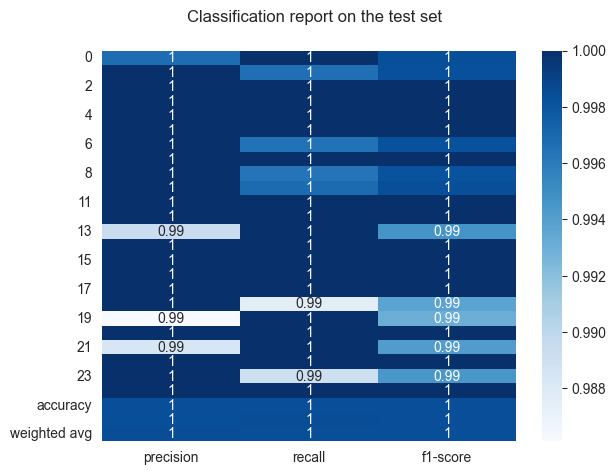

Displaying confusion matrix. Close the figure windows toexit.


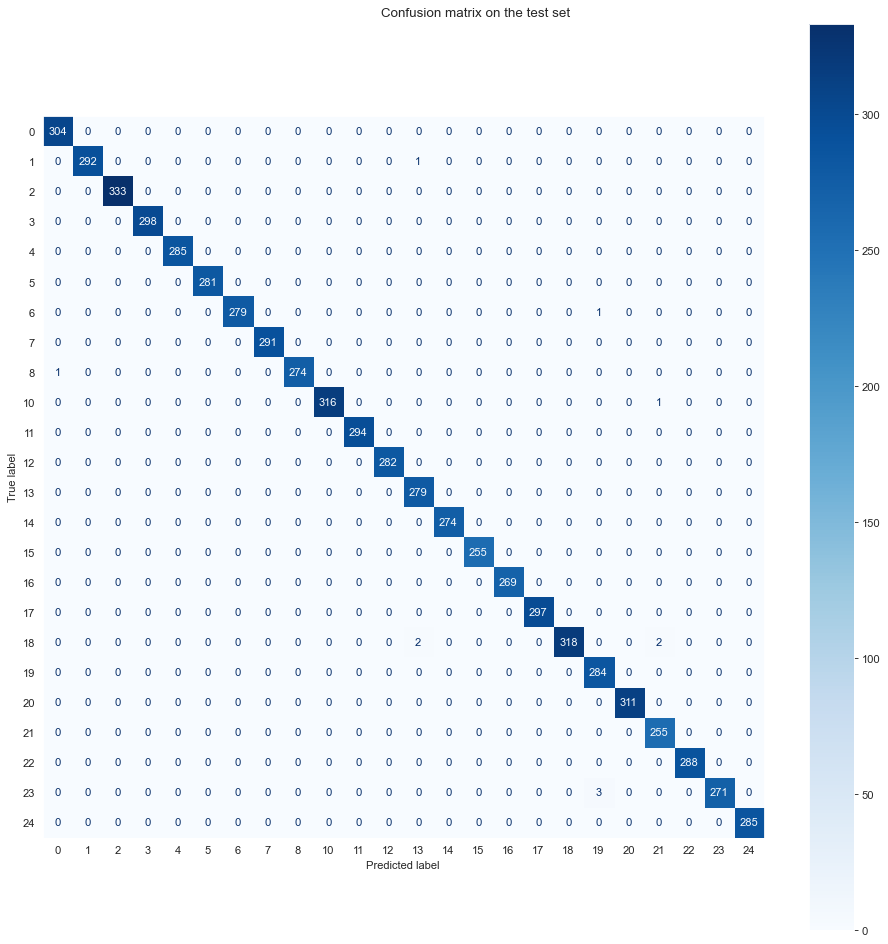

In [5]:
evaluate(model, X_test, y_test)

In [8]:
y_pred = model.predict(X_test)
y_pred

array([ 8,  2, 17, ...,  5, 20, 16], dtype=int64)

In [13]:
idx = []
for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        idx.append(i)
idx

[217, 492, 994, 3193, 3328, 3425, 3620, 5264, 6231, 6629, 6917]

In [24]:
letters = {0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H", 8:"I",
           10:"K", 11:"L", 12:"M", 13:"N", 14:"O", 15:"P", 16:"Q", 17:"R",
           18:"S", 19:"T", 20:"U", 21:"V", 22:"W", 23:"X", 24:"Z"
          }

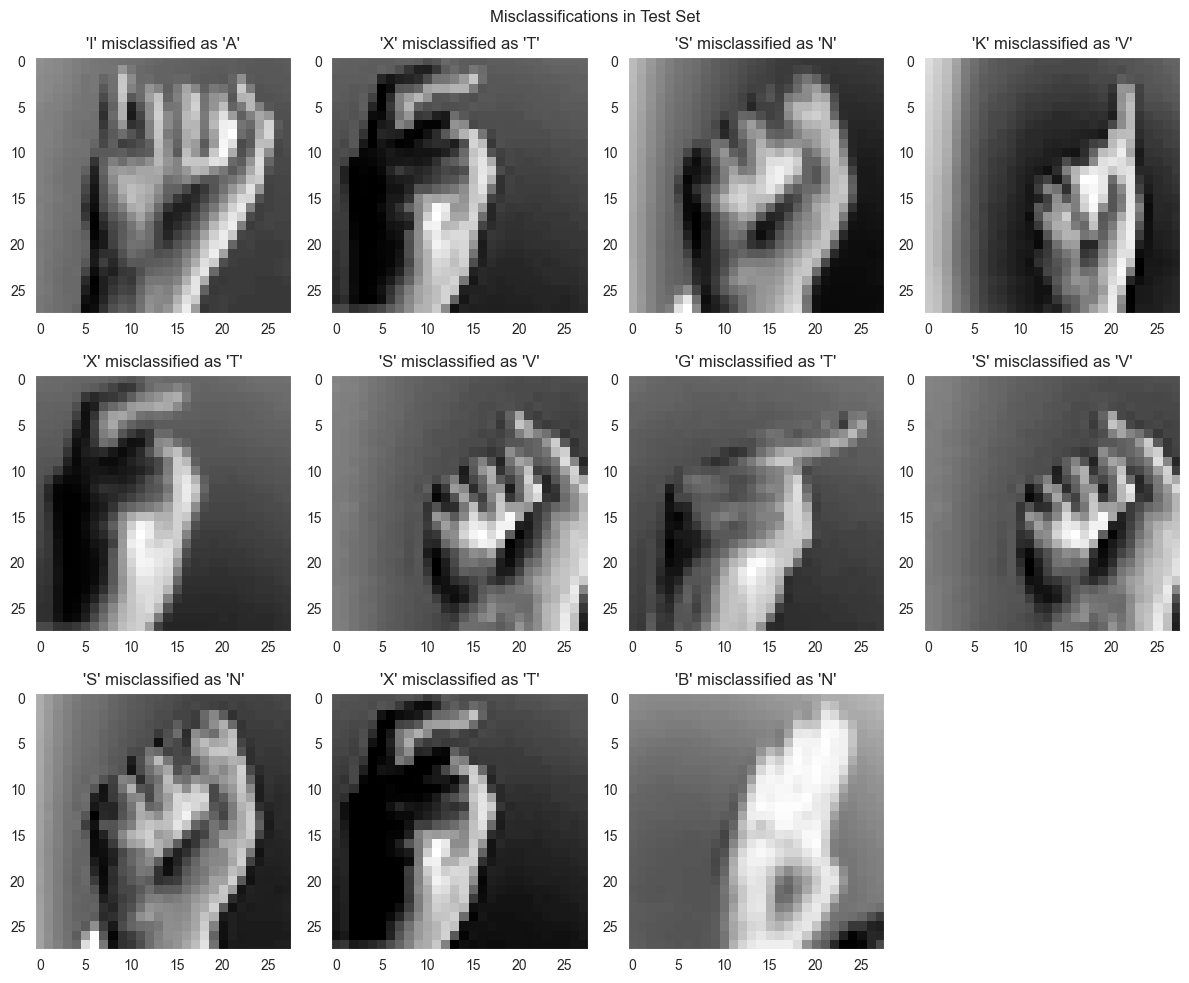

In [51]:
fig, ax = plt.subplots(3,4, figsize=(12,10))
for i, index in enumerate(idx):
    row = i // 4
    col = i % 4
    sample = (X_test[index] * 255).reshape(28,28)
    ax[row][col].imshow(sample, cmap='Greys')
    ax[row][col].set_title(f"'{letters[y_test[index]]}' misclassified as '{letters[y_pred[index]]}'")
fig.delaxes(ax[2][3])
fig.suptitle("Misclassifications in Test Set")
fig.savefig(r"misclassification.png")
plt.tight_layout()